# Garbage image classification

We are setting the imports that we need here at the top to have them in a single place

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Aggregating data, creating data set

We bring our folder and images, and we add each file along with its folder name to the data list and we create a data frame.

In [6]:
def list_folders_in_directory(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

directory_path = "./v1/Garbage classification/"
folders_list = list_folders_in_directory(directory_path)
print(folders_list)


['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
data = []
for folder in folders_list: 
    files = os.listdir(os.path.join(directory_path, folder))
    for file in files:
        data.append({'Folder': folder, 'File_name': file})

df = pd.DataFrame(data)

df.head()

,Folder,File_name
0,cardboard,cardboard1.jpg
1,cardboard,cardboard10.jpg
2,cardboard,cardboard100.jpg
3,cardboard,cardboard101.jpg
4,cardboard,cardboard102.jpg


## Analising the data

First we are checking our data set to see how many photos we have.

In [8]:
df.shape

(2527, 2)

We want to check how many images we have in each category.

In [9]:
df['Folder'].value_counts()

Folder
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

As we ca see, **trash** labes has very few images , it is inbalance related to the rest of labels

We want to get more informations about our images. We can check the extensions.

We can see that we have only 'jpg' files. (Except if you are using MacOS, then you will need to remove the *.DS_Store* files)

In [10]:
df['Extension'] = df['File_name'].str.split('.').str[-1]

print(df['Extension'].value_counts())

df.drop(df[df['Extension']=='DS_Store'].index , inplace=True)

Extension
jpg    2527
Name: count, dtype: int64


We want to check the dimension of images and the format type.

We are adding the dimensions of the image and the format into the dataframe with the help of Pillow library

In [11]:
def get_image_dimensions(df_row):
    file_path = os.path.join(directory_path, df_row['Folder'], df_row['File_name'])
    image = Image.open(file_path)
    width, height = image.size
    return width, height, image.format

df['Image_width'], df['Image_height'], df['Format'] = zip(*df.apply(get_image_dimensions, axis=1))

df.head()

,Folder,File_name,Extension,Image_width,Image_height,Format
0,cardboard,cardboard1.jpg,jpg,512,384,JPEG
1,cardboard,cardboard10.jpg,jpg,512,384,JPEG
2,cardboard,cardboard100.jpg,jpg,512,384,JPEG
3,cardboard,cardboard101.jpg,jpg,512,384,JPEG
4,cardboard,cardboard102.jpg,jpg,512,384,JPEG


We are checking how many different values we have in those two columns.

It seems that all the files have the same size. This means that we do not need to do any transformation to the size of the files.

In [12]:
print(df.Image_width.value_counts())
print(30*'*')
print(df.Image_height.value_counts())

Image_width
512    2527
Name: count, dtype: int64
******************************
Image_height
384    2527
Name: count, dtype: int64


We can also take a look at the files format type.
We can see that all images have **JPEG** format

In [13]:
df['Format'].value_counts()

Format
JPEG    2527
Name: count, dtype: int64

## Data processing

We need to define image parameters, load the data to normalise it and split the data in training dataset and validation dataset.

In [14]:
image_width = 250
image_height = 250
image_size = (image_width, image_height)
batch_size = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    labels="inferred",  
    label_mode="int",  
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    labels="inferred",  
    label_mode="int",  
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


Here we can see that we created a dataset with 6 classes

In [120]:
class_names = train_dataset.class_names
print("Class names:", class_names)


Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


Data visualisation of some images from each class

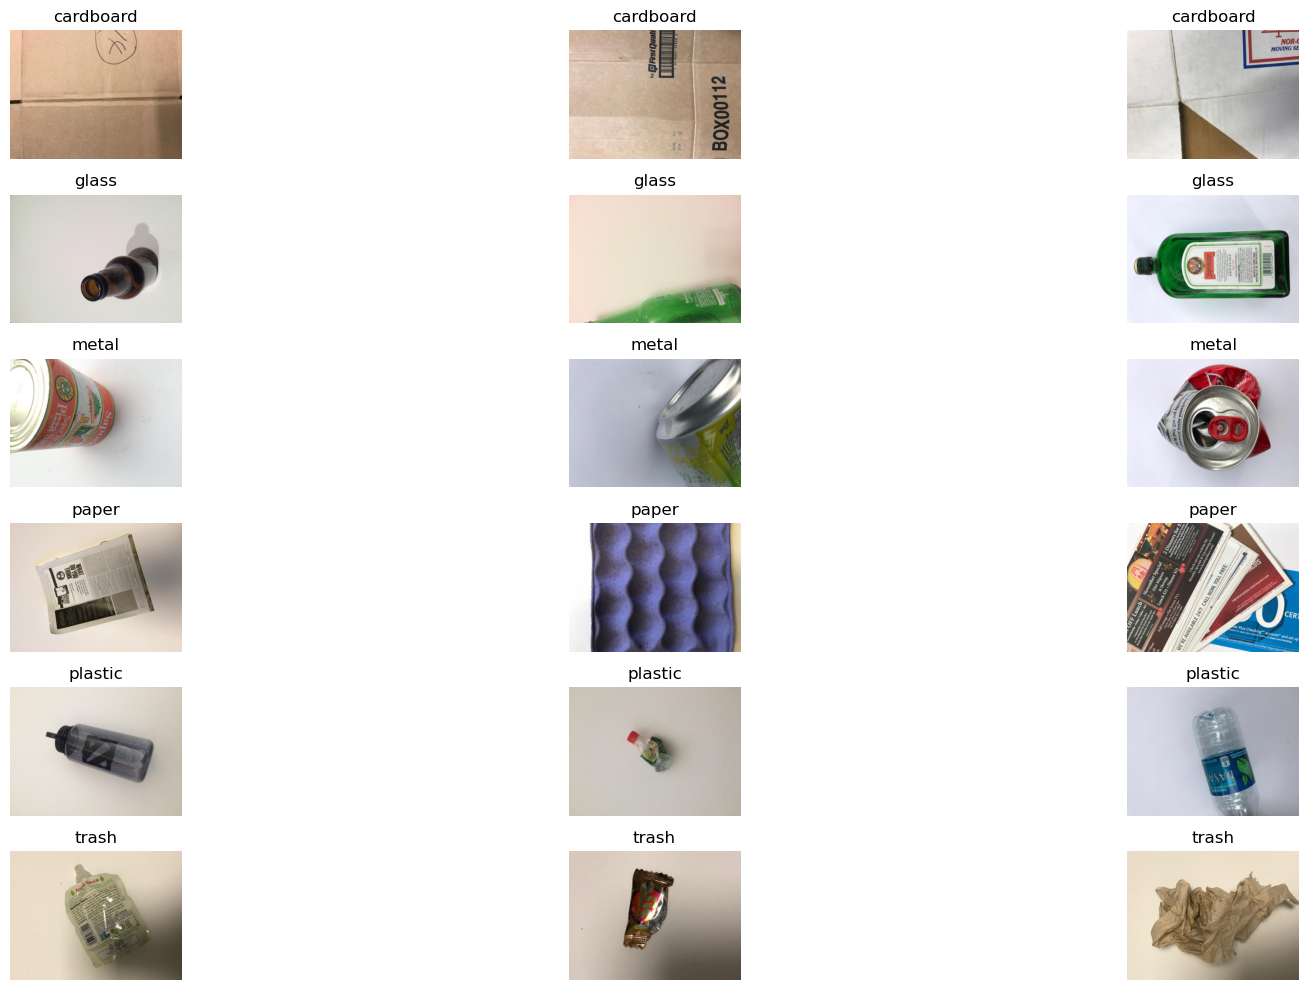

In [121]:
plt.figure(figsize=(20, 10))

num_images_per_class = 3

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_path = os.path.join(directory_path, class_name)
    for img_name in os.listdir(class_path)[:num_images_per_class]:
        if img_name != ".DS_Store":
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)
            class_images.append(image)
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name)
            plt.axis("off")

plt.tight_layout()
plt.show()


We take a look on what we have in train data set, and we can observe that we have a 32 batch size, the size of images are the ones that we provided, and we also have the labels

In [122]:
for images, labels in train_dataset:
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    print("Label batch type:", labels.dtype)
    break 

Image batch shape: (32, 250, 250, 3)
Label batch shape: (32,)
Label batch type: <dtype: 'int32'>


Now we need to normalise the data
We can normalize the data by splitting the value of the pixels with 255, because the range of the values of the pixels are between 0 and 255 and we will get values between 0 an 1

In [123]:
normalization_layer = tf.keras.layers.Rescaling(scale = 1./255)

normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

for images, labels in normalized_train_dataset:
    print("Image batch shape after normalization:", images)
    print("Label batch shape after normalization:", labels)
    print("Label batch type:", labels.dtype)
    break 


Image batch shape after normalization: tf.Tensor(
[[[[0.71011937 0.6434527  0.604237  ]
   [0.70980394 0.6431373  0.6039216 ]
   [0.71085495 0.64810985 0.59712946]
   ...
   [0.63380384 0.504392   0.3828234 ]
   [0.62973064 0.5003188  0.3787502 ]
   [0.6313726  0.5019608  0.3803922 ]]

  [[0.6997279  0.63306123 0.59384555]
   [0.7134109  0.64674425 0.60752857]
   [0.72003144 0.65728635 0.6063059 ]
   ...
   [0.63380384 0.504392   0.3828234 ]
   [0.6313726  0.5019608  0.3803922 ]
   [0.6328735  0.50346166 0.381893  ]]

  [[0.6903844  0.6237177  0.58450204]
   [0.7142902  0.64762354 0.60840786]
   [0.7254902  0.6627451  0.6117647 ]
   ...
   [0.6377254  0.5083136  0.38674498]
   [0.6327059  0.5032941  0.3817255 ]
   [0.63529414 0.5058824  0.38431376]]

  ...

  [[0.9604366  0.79656804 0.65208167]
   [0.9163825  0.7603099  0.6117138 ]
   [0.9058102  0.76325804 0.61788857]
   ...
   [0.48443452 0.4090981  0.29393086]
   [0.47565284 0.41290772 0.28349596]
   [0.5049671  0.44222203 0.3088886

## Define the model

Now that we have our data normalized we need to define the convolutional model.
We will create a sequential model and we add the input from *input_shape*, with 3 Conv layers and an output of 6, because we have 6 classes.


In [124]:
model = Sequential([
    Conv2D(16, (3, 3), padding = 'same', activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding = 'same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding = 'same', activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6)
])


After we created the model now we can compile it

In [125]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])


We can take a look on the model summary

In [126]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 62, 62, 64)        18496     
                                                                 
 flatten_7 (Flatten)         (None, 246016)           

We define a callback function that will save the best model by *val_accuracy*, so every time the validation accuracy will be improved this callback will save the model.

In [15]:
def create_model_checkpoint(model_path):
    model_checkpoint = ModelCheckpoint(f"../models/{model_path}", monitor='val_accuracy', verbose=1, save_best_only=True)
    return model_checkpoint

We train the model, adding the training dataset and validation datas, we set the number of epochs and we add the callback to save the model

In [128]:
epochs = 20
history = model.fit(normalized_train_dataset, validation_data = normalized_val_dataset, epochs=epochs, callbacks=[create_model_checkpoint("initial_model.h5")])

Epoch 1/20


64/64 [==============================] - ETA: 0s - loss: 2.2913 - accuracy: 0.3155
Epoch 1: val_accuracy improved from -inf to 0.39604, saving model to initial_model.h5
64/64 [==============================] - 31s 466ms/step - loss: 2.2913 - accuracy: 0.3155 - val_loss: 1.4298 - val_accuracy: 0.3960
Epoch 2/20
64/64 [==============================] - ETA: 0s - loss: 1.2490 - accuracy: 0.5104
Epoch 2: val_accuracy improved from 0.39604 to 0.47921, saving model to initial_model.h5
64/64 [==============================] - 27s 416ms/step - loss: 1.2490 - accuracy: 0.5104 - val_loss: 1.2496 - val_accuracy: 0.4792
Epoch 3/20
64/64 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.6014
Epoch 3: val_accuracy improved from 0.47921 to 0.56040, saving model to initial_model.h5
64/64 [==============================] - 27s 421ms/step - loss: 1.0536 - accuracy: 0.6014 - val_loss: 1.1368 - val_accuracy: 0.5604
Epoch 4/20
64/64 [==============================] - ETA: 0s - loss: 0

Here we take a look on the model metrics on loss and accuracy.

We can define a method to plot the validation and accuracy, to reuse it.

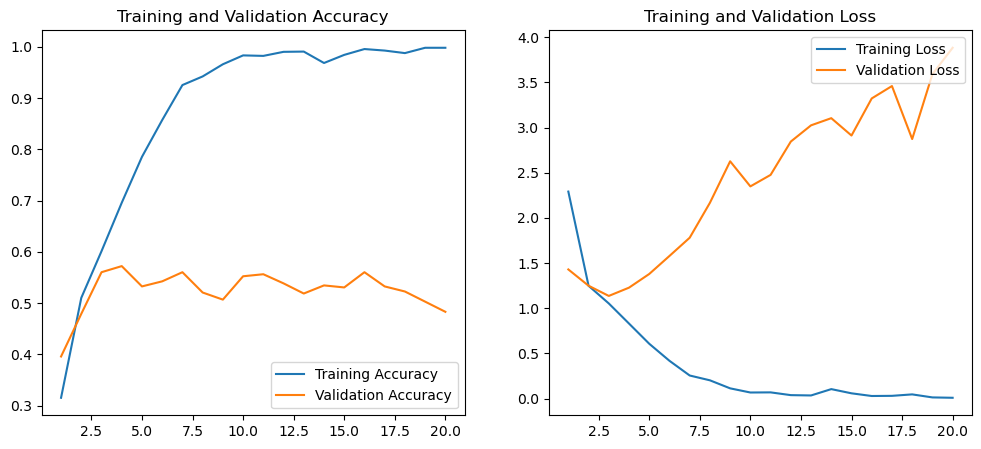

In [218]:
def plot_validation_training(history):

    acc = history['accuracy']
    val_acc = history['val_accuracy']

    loss = history['loss']
    val_loss = history['val_loss']

    epochs = len(acc)
    epochs_range = range(1, epochs +1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_validation_training(history.history)

We can see that accuracy is increasing but validation accuracy is dropping after a while and remains under 55%.

This means that our model is not performing well, what we can try next is to use data augumentation or add more images.

## Data augumentation

We will use image data generator method , to generate images in our training process.

In [16]:
train_datagen = ImageDataGenerator(
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=15,
                                   zoom_range=0.1,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.1,
                                   fill_mode="nearest",
                                   rescale=1./255.,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(directory_path, target_size=(image_width, image_height), batch_size=32, class_mode="sparse", subset='training')
validation_generator = train_datagen.flow_from_directory(directory_path, target_size=(image_width, image_height), batch_size=32,class_mode="sparse", subset='validation')

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


Now we will create another model to check out how it will behave with data generator

In [131]:
aug_model = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(6) 
])

We are compiling the model

In [132]:
aug_model.compile(optimizer=Adam(learning_rate=0.001),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

We are training the new model with augmented data *(train_generator / validation_data)*

In [133]:
epochs = 30
history_aug = aug_model.fit(train_generator, validation_data = validation_generator, epochs=epochs, callbacks=[create_model_checkpoint("aug_model.h5")])

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 2.4123 - accuracy: 0.2984
Epoch 1: val_accuracy improved from -inf to 0.32604, saving model to aug_model.h5
64/64 [==============================] - 55s 848ms/step - loss: 2.4123 - accuracy: 0.2984 - val_loss: 1.5806 - val_accuracy: 0.3260
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 1.3927 - accuracy: 0.4264
Epoch 2: val_accuracy improved from 0.32604 to 0.37773, saving model to aug_model.h5
64/64 [==============================] - 54s 849ms/step - loss: 1.3927 - accuracy: 0.4264 - val_loss: 1.4470 - val_accuracy: 0.3777
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 1.2527 - accuracy: 0.5040
Epoch 3: val_accuracy improved from 0.37773 to 0.38370, saving model to aug_model.h5
64/64 [==============================] - 54s 854ms/step - loss: 1.2527 - accuracy: 0.5040 - val_loss: 1.4895 - val_accuracy: 0.3837
Epoch 4/30
64/64 [==============================] - ETA: 0s - loss: 1.

We can plot the accuracy for the new model

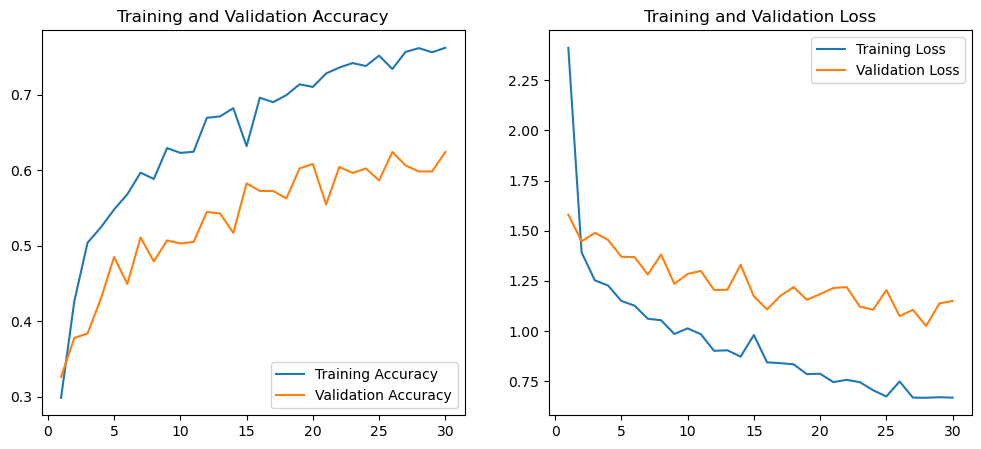

In [219]:
plot_validation_training(history_aug.history)

We will train more because our model is still at a low accuracy

First we will load our saved model and then we will start training from there.

In [135]:
aug_model = tf.keras.models.load_model('../models/aug_model.h5')

epochs = 30
history_aug_1 = aug_model.fit(train_generator, validation_data = validation_generator, epochs=epochs, callbacks=[create_model_checkpoint("aug_model.h5")])

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.7653
Epoch 1: val_accuracy improved from -inf to 0.57654, saving model to aug_model.h5
64/64 [==============================] - 56s 866ms/step - loss: 0.6666 - accuracy: 0.7653 - val_loss: 1.1178 - val_accuracy: 0.5765
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.7500
Epoch 2: val_accuracy improved from 0.57654 to 0.58449, saving model to aug_model.h5
64/64 [==============================] - 55s 853ms/step - loss: 0.6987 - accuracy: 0.7500 - val_loss: 1.1921 - val_accuracy: 0.5845
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.7362
Epoch 3: val_accuracy improved from 0.58449 to 0.59245, saving model to aug_model.h5
64/64 [==============================] - 54s 848ms/step - loss: 0.7071 - accuracy: 0.7362 - val_loss: 1.1331 - val_accuracy: 0.5924
Epoch 4/30
64/64 [==============================] - ETA: 0s - loss: 0.

We can merge the two histories from both training sessions

In [184]:
loss = history_aug.history['loss'] + history_aug_1.history['loss']
accuracy = history_aug.history['accuracy'] + history_aug_1.history['accuracy']
val_loss = history_aug.history['val_loss'] + history_aug_1.history['val_loss']
val_accuracy = history_aug.history['val_accuracy'] + history_aug_1.history['val_accuracy']

merged_history = {
    'loss': loss,
    'accuracy': accuracy,
    'val_loss': val_loss,
    'val_accuracy': val_accuracy
}

Then we can plot the combined results

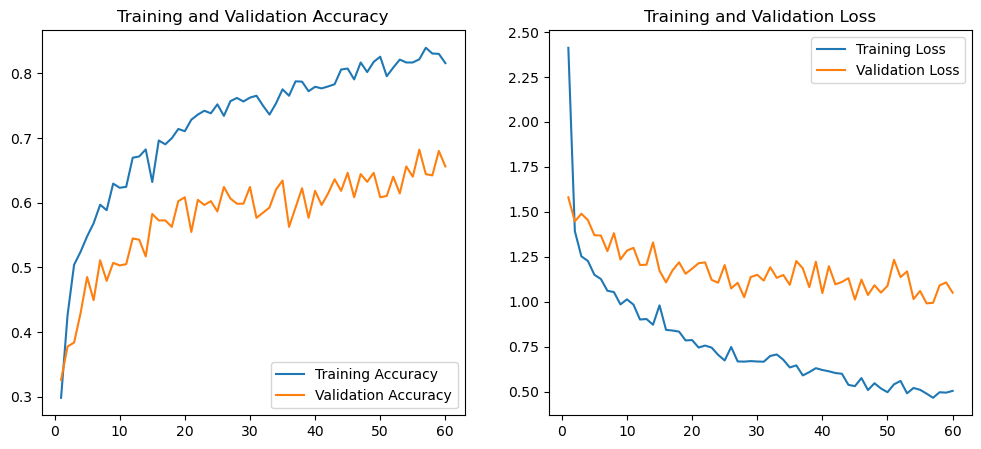

In [220]:
plot_validation_training(merged_history)

Even though we did not end up in having a very good accuracy, we are not able to improve our validation accuracy too much. This is probably related to the fact that we do not have a large set of images for our problem.

What we can do is to use a pretrained model so that we could try to increase our model performance.

## Pretrained model (TRANSFER LEARNING)

We will try to use the pretrained model *InceptionV3*

First we need to define our model from the existing one.
- *include_top = False* - this will get our model without the classification layers
- *weights='imagenet'* - here we will get the existing pretrained weights of the model

In [195]:
iv3_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(image_height, image_width, 3),
)

We block the layers of the pretrained model to not be trainable and we will summarize to see the model arhitecture.

In [196]:
iv3_model.trainable = False
iv3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 124, 32  96         ['conv2d_27[0][0]']              
 alization)                     )                                                      

We define the Top Layers(Head layers)
Basically we construct a custom classification head on top of the InceptionV3 base model.

In [202]:
x = iv3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(iv3_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
predictions = Dense(6)(x)

We attach the top layer and create a model

In [205]:
pretrained_model = Model(inputs=iv3_model.input, outputs=predictions)
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 124, 32  96         ['conv2d_27[0][0]']              
 alization)                     )                                                             

                                                                                                  
 activation_10 (Activation)     (None, 28, 28, 96)   0           ['batch_normalization_10[0][0]'] 
                                                                                                  
 activation_11 (Activation)     (None, 28, 28, 32)   0           ['batch_normalization_11[0][0]'] 
                                                                                                  
 mixed0 (Concatenate)           (None, 28, 28, 256)  0           ['activation_5[0][0]',           
                                                                  'activation_7[0][0]',           
                                                                  'activation_10[0][0]',          
                                                                  'activation_11[0][0]']          
                                                                                                  
 conv2d_42

We will augment our data but we also apply a preprocessing function that will convert our data to match our pretrained_model.

In [17]:
directory_path = "./v1/Garbage classification/"

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1, 
    ).flow_from_directory(
    directory=directory_path, target_size=image_size,shuffle=True, class_mode="sparse", batch_size=32, subset='training')

valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=directory_path, target_size=image_size, shuffle = False, class_mode="sparse", batch_size=32, subset='validation')

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


We compile the preTrainedModel

In [212]:
pretrained_model.compile(
    optimizer=Adam(), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

Train the model with Augumentation (image generator)

In [213]:
pretrained_model_history = pretrained_model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[create_model_checkpoint("pretrained_model.h5")])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 1.0727 - accuracy: 0.6226
Epoch 1: val_accuracy improved from -inf to 0.77291, saving model to pretrained_model.h5
72/72 [==============================] - 79s 1s/step - loss: 1.0727 - accuracy: 0.6226 - val_loss: 0.7421 - val_accuracy: 0.7729
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.7140 - accuracy: 0.7715
Epoch 2: val_accuracy improved from 0.77291 to 0.80478, saving model to pretrained_model.h5
72/72 [==============================] - 73s 1s/step - loss: 0.7140 - accuracy: 0.7715 - val_loss: 0.6036 - val_accuracy: 0.8048
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.5440 - accuracy: 0.8115
Epoch 3: val_accuracy improved from 0.80478 to 0.83665, saving model to pretrained_model.h5
72/72 [==============================] - 75s 1s/step - loss: 0.5440 - accuracy: 0.8115 - val_loss: 0.4642 - val_accuracy: 0.8367
Epoch 4/20
72/72 [==============================] - ETA: 0

We can now see how our pretrained model behaved in the training session

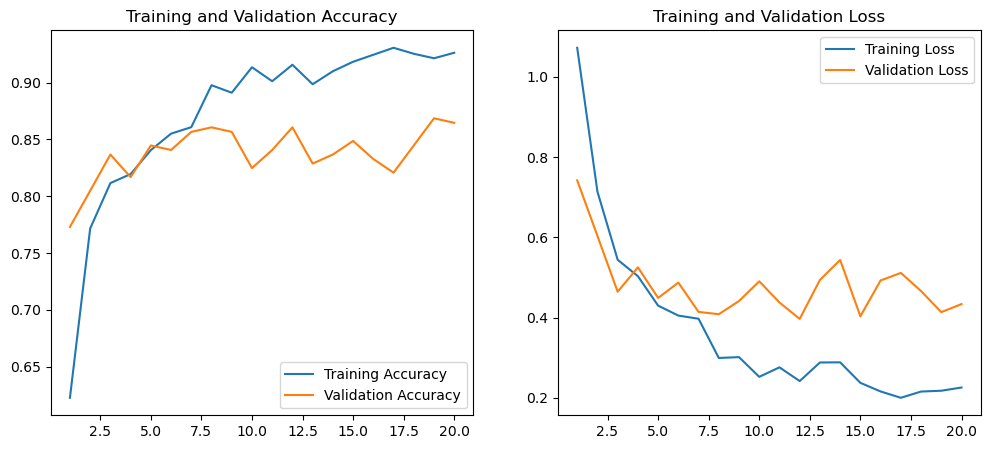

In [221]:
plot_validation_training(pretrained_model_history.history)

We can see that our validation accuracy is now around 86-87% and we can check how well it behaves on new data.
So we load the best saved model.

In [235]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

probability_model = tf.keras.Sequential([pretrained_model, 
                                         tf.keras.layers.Softmax()])

In [18]:
valid_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
    validation_split=0.1).flow_from_directory(
    directory=directory_path, target_size=image_size, shuffle = False, class_mode="sparse", batch_size=32, subset='validation')

Found 251 images belonging to 6 classes.


We will create a function that will help us in getting the predictions for every image from validation data batches

In [19]:
def prediction_generator(test_images):
    k = 0
    for x in test_images:
        k += len(x[1])
        yield x[0], x[1] 
        if k >= test_images.n:
            break

We can use the model to predict the labels for every image from the valid_batches.

We also calculate the accuracy_score, the difference between the actual labels and the predicted ones.

In [260]:
probabilities = probability_model.predict(prediction_generator(valid_batches))

predicted_labels = np.argmax(probabilities, axis=1)

actual_labels=valid_batches.labels
accuracy_score(predicted_labels, actual_labels)

8/8 [==============================] - 6s 724ms/step


0.8685258964143426

We will define a function in which we will plot the confusion matrix, it will basically show for every class the actual versus predicted labels.

In [26]:
def plot_confusion_matrix(batches, actual_labels, predicted_labels):
    class_= valid_batches.class_indices.keys()
    cm = confusion_matrix(actual_labels, predicted_labels)

    fig = plt.figure(figsize=(8, 6))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
    ax.set_xlabel('Predicted classes', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('Actual classes', fontsize=20)
    ax.yaxis.set_ticklabels(class_, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('', fontsize=60)

    plt.show()

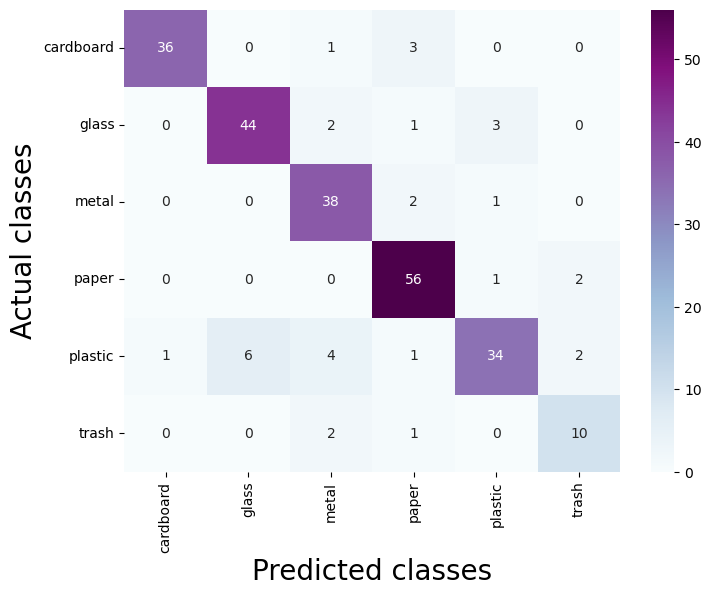

In [266]:
plot_confusion_matrix(valid_batches, actual_labels, predicted_labels)

What we can do now is to try to fine tuned the model by lowering the learning rate.

In [267]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

We reduce the learning rate from 0.001 to 0.0001, and we train the loaded model with 20 epochs to see if we will have improvements.

In [268]:
pretrained_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [269]:
finetuned_model_history = pretrained_model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[create_model_checkpoint("pretrained_model.h5")])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9398
Epoch 1: val_accuracy improved from -inf to 0.88446, saving model to pretrained_model.h5
72/72 [==============================] - 93s 1s/step - loss: 0.1688 - accuracy: 0.9398 - val_loss: 0.3598 - val_accuracy: 0.8845
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.1547 - accuracy: 0.9411
Epoch 2: val_accuracy did not improve from 0.88446
72/72 [==============================] - 77s 1s/step - loss: 0.1547 - accuracy: 0.9411 - val_loss: 0.3663 - val_accuracy: 0.8805
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9591
Epoch 3: val_accuracy did not improve from 0.88446
72/72 [==============================] - 78s 1s/step - loss: 0.1350 - accuracy: 0.9591 - val_loss: 0.4940 - val_accuracy: 0.8805
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.9521
Epoch 4: val_accuracy did not improve from 0.8

We will load the best model again as we have some improvements.

In [271]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

probability_model = tf.keras.Sequential([pretrained_model, 
                                         tf.keras.layers.Softmax()])

We will make predictions again

In [272]:
probabilities = probability_model.predict(prediction_generator(valid_batches))

predicted_labels = np.argmax(probabilities, axis=1)

actual_labels=valid_batches.labels
accuracy_score(predicted_labels, actual_labels)

8/8 [==============================] - 9s 871ms/step


0.896414342629482

We will create the confusion matrix for the improved model

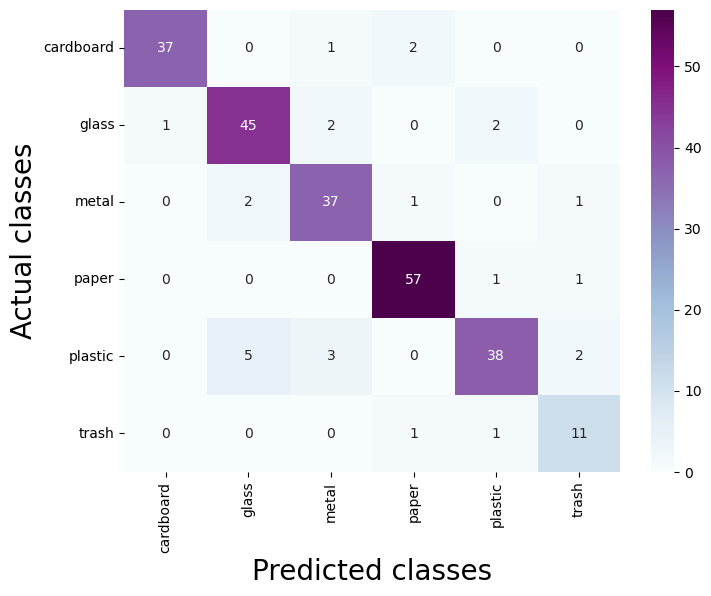

In [273]:
plot_confusion_matrix(valid_batches, actual_labels, predicted_labels)

Another thing that we can do it to unfreeze more layers so that our model can learn more.

First we are making our pretrained model to be completely trainable.

In [296]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

pretrained_model.trainable = True
pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 124, 32  96         ['conv2d_27[0][0]']              
 alization)                     )                                                             

Then we will choose to train the top 2 inception blocks, we will freeze the first 249 layers.

In [298]:
for layer in pretrained_model.layers[:249]:
    layer.trainable = False

pretrained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 124, 124, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 124, 124, 32  96         ['conv2d_27[0][0]']              
 alization)                     )                                                             

We are compiling the model

In [299]:
pretrained_model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

Train again the pretrained model

In [300]:
more_layers_model_history = pretrained_model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[create_model_checkpoint("pretrained_model.h5")])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.3084 - accuracy: 0.8946
Epoch 1: val_accuracy improved from -inf to 0.82470, saving model to pretrained_model.h5
72/72 [==============================] - 97s 1s/step - loss: 0.3084 - accuracy: 0.8946 - val_loss: 0.5941 - val_accuracy: 0.8247
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.1785 - accuracy: 0.9416
Epoch 2: val_accuracy did not improve from 0.82470
72/72 [==============================] - 94s 1s/step - loss: 0.1785 - accuracy: 0.9416 - val_loss: 0.6871 - val_accuracy: 0.8207
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9565
Epoch 3: val_accuracy improved from 0.82470 to 0.86056, saving model to pretrained_model.h5
72/72 [==============================] - 87s 1s/step - loss: 0.1595 - accuracy: 0.9565 - val_loss: 0.5163 - val_accuracy: 0.8606
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9490
Epoch

We can see that the validation accuracy is a little better.

Let's try to improve it by lowering again the learning rate.

In [20]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

In [21]:
pretrained_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [22]:
finetune_more_layers_model_history = pretrained_model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[create_model_checkpoint("pretrained_model.h5")])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.0482 - accuracy: 0.9851
Epoch 1: val_accuracy improved from -inf to 0.86454, saving model to pretrained_model.h5
72/72 [==============================] - 88s 1s/step - loss: 0.0482 - accuracy: 0.9851 - val_loss: 0.4331 - val_accuracy: 0.8645
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9811
Epoch 2: val_accuracy improved from 0.86454 to 0.91235, saving model to pretrained_model.h5
72/72 [==============================] - 90s 1s/step - loss: 0.0586 - accuracy: 0.9811 - val_loss: 0.4105 - val_accuracy: 0.9124
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.9877
Epoch 3: val_accuracy did not improve from 0.91235
72/72 [==============================] - 90s 1s/step - loss: 0.0430 - accuracy: 0.9877 - val_loss: 0.3859 - val_accuracy: 0.8964
Epoch 4/20
72/72 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9890
Epoch

Our validation accuracy has increased. Let's see how the confusion matrix looks now.

In [23]:
pretrained_model = tf.keras.models.load_model("../models/pretrained_model.h5")

probability_model = tf.keras.Sequential([pretrained_model, 
                                         tf.keras.layers.Softmax()])

In [24]:
probabilities = probability_model.predict(prediction_generator(valid_batches))

predicted_labels = np.argmax(probabilities, axis=1)

actual_labels=valid_batches.labels
accuracy_score(predicted_labels, actual_labels)

8/8 [==============================] - 7s 710ms/step


0.9322709163346613

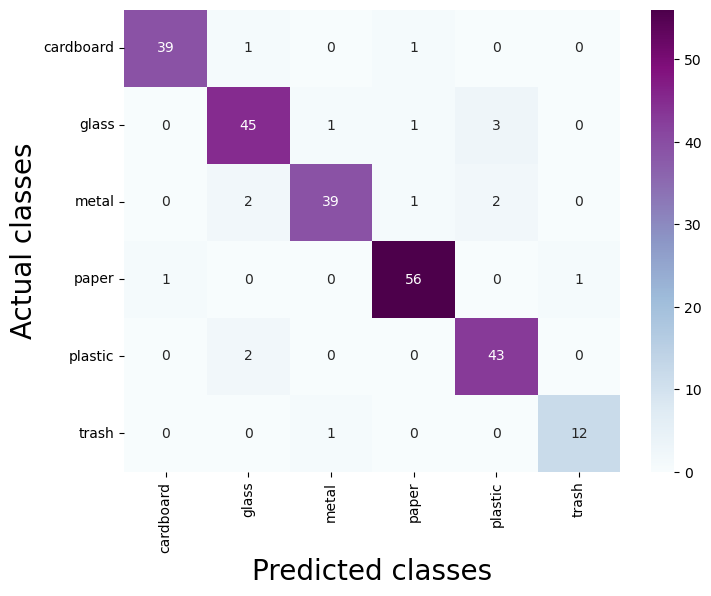

In [27]:
plot_confusion_matrix(valid_batches, predicted_labels, actual_labels)

We will try to classify some images that we did not train on. Images that are taken from a different source than our dataset.

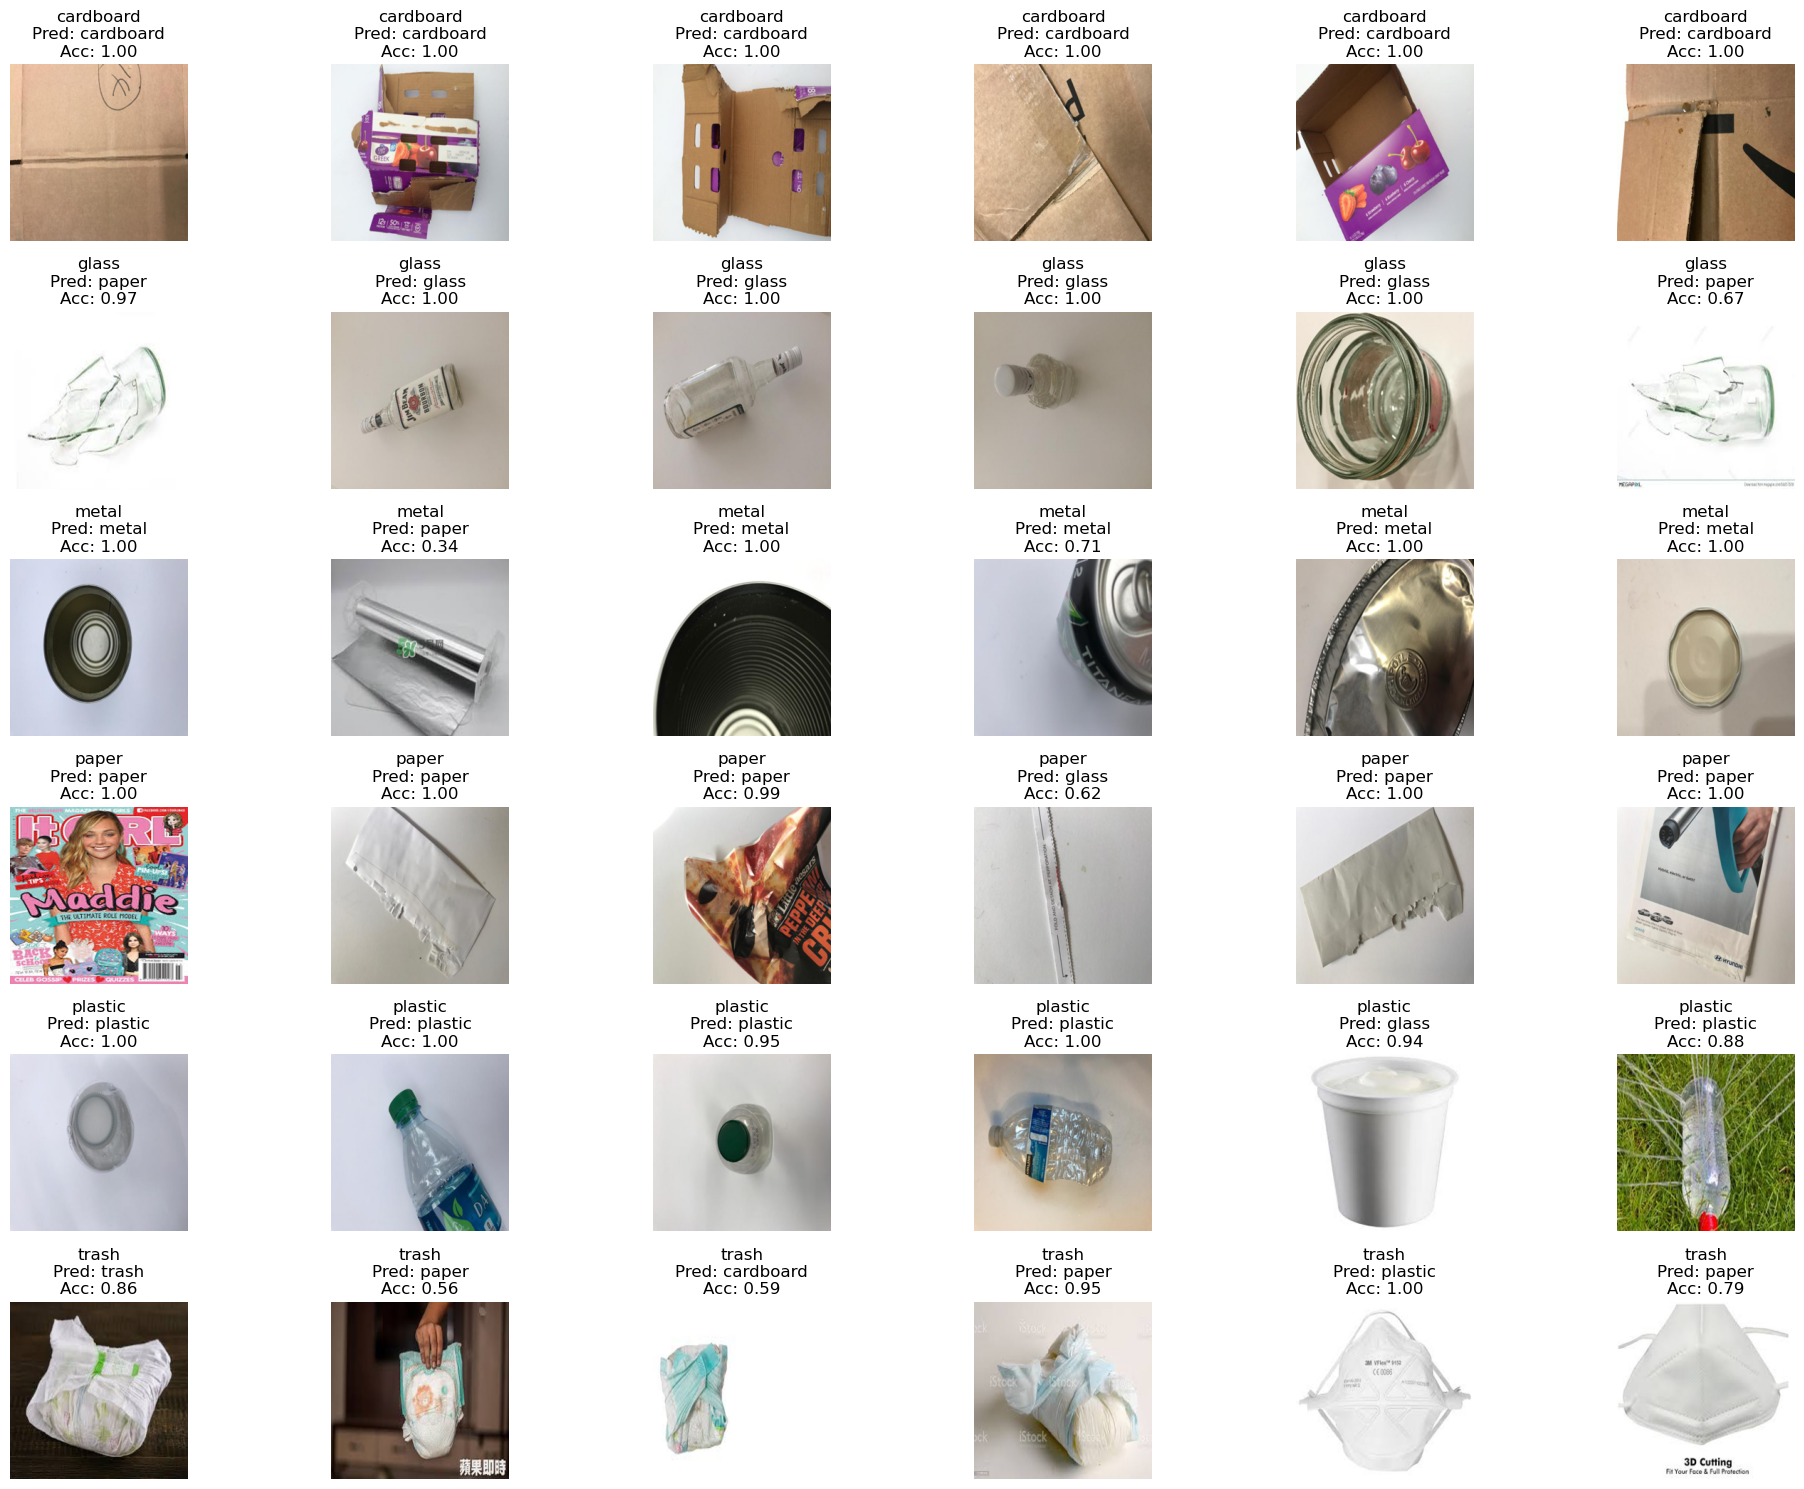

In [28]:
data_directory = "validation_images"

class_names = [name for name in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, name))]

plt.figure(figsize=(20, 15))

num_images_per_class = 6

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_predictions =[]
    class_accuracy =[]
    class_path = os.path.join(data_directory, class_name)
    for img_name in os.listdir(class_path)[:num_images_per_class]:
        if img_name != ".DS_Store":
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path)

            image = image.resize(image_size)

            image_array = np.array(image)

            image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

            image_tensor = tf.expand_dims(image_tensor, axis=0)
            
            predictions = probability_model.predict(image_tensor, verbose=0)
            predicted_index = np.argmax(predictions)
            predicted_label = class_names[predicted_index]
            accuracy = np.round(np.max(predictions), 2)
            class_images.append(image)
            class_predictions.append("\nPred: "+ predicted_label)
            class_accuracy.append(f"\nAcc: {accuracy:.2f}")
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name + class_predictions[k] + class_accuracy[k])
            plt.axis("off")

plt.tight_layout()
plt.show()

We reached a validation accuracy that is around 93%. And what we can see is that there are still images that are not correctly identified. This is mostly visible in the *Trash* category.
This is because the data that we used for training contains photos that are not similar to the ones that we classified above.

This shows how important is to have a variate training dataset that should cover as many forms and patterns that we want to recognize.